In [17]:
!pip install sentence_transformers
!pip install imblearn
!pip install tensorflow
!pip install python-bidi

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import re
# import arabic_reshaper
from bidi.algorithm import get_display
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
class ArabicSentimentAnalyzer:
    def __init__(self, model_name='paraphrase-multilingual-mpnet-base-v2'):
        """
        Initialize the analyzer with advanced configurations
        """
        self.sentence_transformer = SentenceTransformer(model_name)
        self.label_encoder = LabelEncoder()
        self.model = None
        self.target_names = None

    def preprocess_text(self, text):
        """
        Enhanced text preprocessing for Arabic text
        """
        if pd.isna(text):
            return ""

        # Convert to string
        text = str(text)

        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        # Remove mentions
        text = re.sub(r'@\w+', '', text)

        # Remove hashtags
        text = re.sub(r'#\w+', '', text)

        # Remove emojis and special characters
        text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)

        # Remove Arabic diacritics
        text = re.sub(r'[\u064B-\u065F\u0670]', '', text)

        # Normalize Arabic characters
        text = text.replace('ى', 'ي')
        text = text.replace('ة', 'ه')

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def create_embeddings(self, texts):
        """
        Create sentence embeddings using Sentence Transformer
        """
        return self.sentence_transformer.encode(
            texts,
            show_progress_bar=True,
            convert_to_numpy=True
        )

    def prepare_data(self, df, text_column, label_column):
        """
        Prepare data with advanced preprocessing
        """
        # Preprocess texts
        print("Preprocessing texts...")
        df['cleaned_text'] = df[text_column].apply(self.preprocess_text)

        # Remove empty texts
        df = df[df['cleaned_text'].str.strip() != '']

        # Create embeddings
        print("Creating embeddings...")
        embeddings = self.create_embeddings(df['cleaned_text'].tolist())

        # Encode labels and store target names as strings
        print("Encoding labels...")
        self.target_names = df[label_column].unique().astype(str)
        y = self.label_encoder.fit_transform(df[label_column])

        return embeddings, y

    # def apply_smote(self, X, y):
    #     """
    #     Advanced SMOTE with more robust resampling
    #     """
    #     smote = SMOTE(
    #         sampling_strategy='auto',  # Balance all classes
    #         random_state=42,
    #         k_neighbors=3  # Adjust based on minority class size
    #     )
    #     X_resampled, y_resampled = smote.fit_resample(X, y)
    #     return X_resampled, y_resampled
    def apply_smote(self, X, y):
      """
      Apply SMOTE with fixed sampling strategy and type checking
      """
      # Convert inputs to numpy arrays if they aren't already
      X = np.array(X)
      y = np.array(y)

      # Print initial class distribution
      print("\nInitial class distribution:")
      unique, counts = np.unique(y, return_counts=True)
      for u, c in zip(unique, counts):
          print(f"Class {u}: {c}")

      # Calculate the desired number of samples for each class
      # Make all classes equal to the majority class
      max_samples = max(np.bincount(y))

      # Define sampling strategy to make all classes have the same number of samples
      sampling_strategy = {}
      for class_label in np.unique(y):
          if np.sum(y == class_label) < max_samples:
              sampling_strategy[class_label] = max_samples

      print("\nTarget samples per class:", max_samples)
      print("Sampling strategy:", sampling_strategy)

      # Apply SMOTE with explicit sampling strategy
      smote = SMOTE(
          sampling_strategy=sampling_strategy,
          random_state=42,
          k_neighbors=min(5, min(np.bincount(y)) - 1)  # Ensure k_neighbors is valid
      )

      try:
          X_resampled, y_resampled = smote.fit_resample(X, y)

          # Print final class distribution
          print("\nFinal class distribution:")
          unique, counts = np.unique(y_resampled, return_counts=True)
          for u, c in zip(unique, counts):
              print(f"Class {u}: {c}")

          return X_resampled, y_resampled

      except ValueError as e:
          print(f"Error applying SMOTE: {str(e)}")
          print("Falling back to original data...")
          return X, y


    def build_model(self, input_dim, num_classes):
        """
        More sophisticated neural network architecture
        """
        model = Sequential([
            # Input layer with L2 regularization
            Dense(512, activation='relu',
                  input_dim=input_dim,
                  kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.4),

            # Hidden layers with increased complexity

            Dense(256, activation='relu',
                  kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(128, activation='relu',
                  kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.2),

            # Output layer
            Dense(num_classes, activation='softmax')
        ])

        # Advanced optimizer with lower learning rate
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0001,
            beta_1=0.9,
            beta_2=0.999
        )

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train_and_evaluate(self, df, text_column, label_column, test_size=0.2):
        """
        Comprehensive training and evaluation with advanced techniques
        """
        # Prepare data
        X, y = self.prepare_data(df, text_column, label_column)

        # Split data with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=test_size,
            random_state=42,
            stratify=y
        )

        # Apply SMOTE to training data
        print("Applying SMOTE...")
        X_train_resampled, y_train_resampled = self.apply_smote(X_train, y_train)

        # Verify SMOTE results
        print("\nTraining set class distribution after SMOTE:")
        unique, counts = np.unique(y_train_resampled, return_counts=True)
        for u, c in zip(unique, counts):
            print(f"Class {u}: {c}")


        # Build model
        print("Building model...")
        self.model = self.build_model(X_train.shape[1], len(np.unique(y)))

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=0.00001
        )

        # Training with more sophisticated approach
        history = self.model.fit(
            X_train_resampled,
            y_train_resampled,
            validation_split=0.2,
            epochs=200,  # Increased epochs
            batch_size=64,  # Adjusted batch size
            class_weight=self._compute_class_weights(y_train_resampled),
            callbacks=[early_stopping, reduce_lr]
        )

        # Evaluate model
        print("\nEvaluating model...")
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(
            y_test,
            y_pred_classes,
            target_names=self.target_names,
            zero_division=1  # Handle potential division by zero
        )
        print(report)

        # Visualizations
        self._plot_results(y_test, y_pred_classes)

        return history, report

    def _compute_class_weights(self, y):
        """
        Compute class weights to handle class imbalance
        """
        from sklearn.utils.class_weight import compute_class_weight

        # Compute balanced class weights
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        )

        # Convert to dictionary
        return dict(enumerate(class_weights))

    def _plot_results(self, y_true, y_pred):
        """
        Generate comprehensive visualizations
        """
        # Confusion Matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=self.target_names,
            yticklabels=self.target_names
        )
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()


    def predict(self, texts):
        """
        Predict sentiment for new texts
        """
        if not self.model:
            raise ValueError("Model hasn't been trained yet!")

        # Preprocess texts
        cleaned_texts = [self.preprocess_text(text) for text in texts]

        # Create embeddings
        embeddings = self.create_embeddings(cleaned_texts)

        # Make predictions
        predictions = self.model.predict(embeddings)
        predicted_classes = np.argmax(predictions, axis=1)

        # Convert numeric predictions to original labels
        predicted_labels = self.label_encoder.inverse_transform(predicted_classes)

        return predicted_labels, predictions

In [3]:
df = pd.read_parquet("hf://datasets/arbml/ASTD/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [ ]:
df.head()

,tweet,label
0,بعد استقالة رئيس #المحكمة_الدستورية ننتظر استق...,1
1,أهنئ الدكتور أحمد جمال الدين، القيادي بحزب مصر...,2
2,البرادعي يستقوى بامريكا مرةاخرى و يرسل عصام ال...,3
3,#الحرية_والعدالة | شاهد الآن: #ليلة_الاتحادية ...,1
4,الوالدة لو اقولها بخاطري حشيشة تضحك بس من اقول...,0


In [ ]:
# show the number of each value in the label column

df['label'].value_counts()

,count
label,
1,6470
3,1642
0,805
2,777


Preprocessing texts...
Creating embeddings...


Batches:   0%|          | 0/298 [00:00<?, ?it/s]

Encoding labels...
Applying SMOTE...

Initial class distribution:
Class 0: 634
Class 1: 5067
Class 2: 609
Class 3: 1302

Target samples per class: 5067
Sampling strategy: {0: 5067, 2: 5067, 3: 5067}

Final class distribution:
Class 0: 5067
Class 1: 5067
Class 2: 5067
Class 3: 5067

Training set class distribution after SMOTE:
Class 0: 5067
Class 1: 5067
Class 2: 5067
Class 3: 5067
Building model...
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4471 - loss: 2.6370 - val_accuracy: 0.0032 - val_loss: 3.3944 - learning_rate: 1.0000e-04
Epoch 2/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5917 - loss: 2.2174 - val_accuracy: 0.0508 - val_loss: 3.4499 - learning_rate: 1.0000e-04
Epoch 3/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6367 - loss: 2.0942 - val_accuracy: 0.1046 - val_loss: 3.3636 - learning_rate: 1.0000e-04
Epoch 4/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6637 - loss: 1.9900 - val_accuracy: 0.1539 - val_loss: 3.1850 - learning_rate: 1.0000e-04
Epoch 5/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6924 - loss: 1.9097 - val_accuracy: 0.1359 - val_loss: 3.2995 - learning_rate: 1.0000e-04
Epoch 6/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7035 - loss: 1.8559 - val_accuracy: 0.1670 - val_loss: 3.1222 - learning_rate: 1.0000e-04
Epoch 7/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy

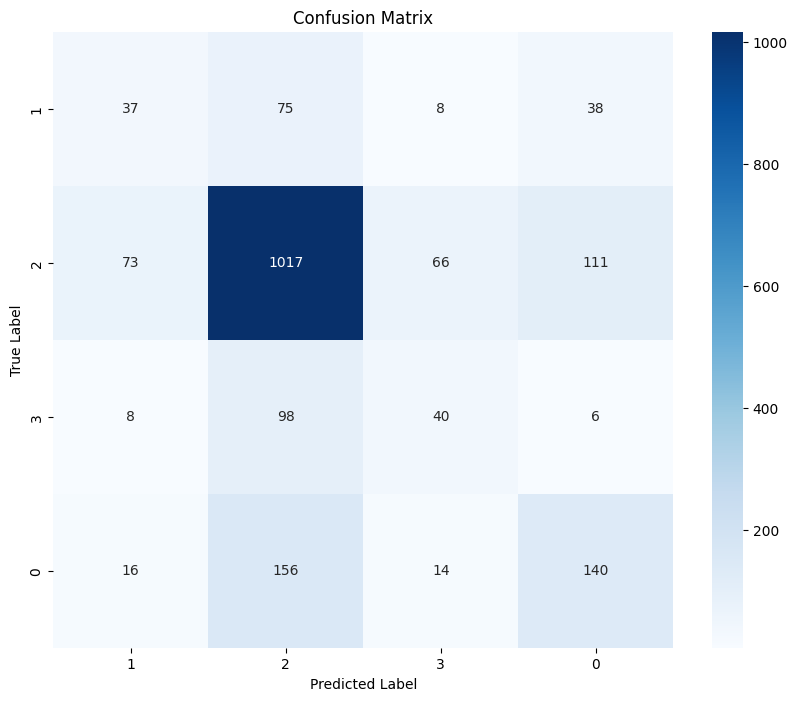

In [ ]:
# Example usage
# Assuming your dataset is in a pandas DataFrame called 'df'
# with columns 'text' and 'label'

# Initialize the analyzer
analyzer = ArabicSentimentAnalyzer() # efederici/sentence-bert-base

# Train and evaluate the model
history = analyzer.train_and_evaluate(
    df,
    text_column='tweet',
    label_column='label'
)


In [ ]:
history, report = history

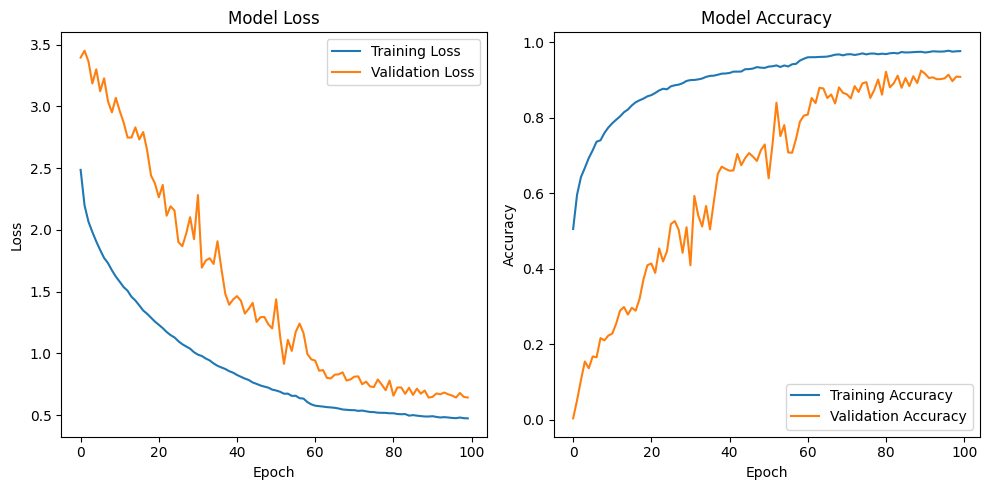

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

# Make predictions on new texts
new_texts = [
    "أنا سعيد جداً اليوم",
    "هذا المنتج سيء للغاية",
    "السماء زرقاء"
]
predictions, confidence_scores = analyzer.predict(new_texts)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [ ]:
print(predictions)

[1 3 1]
